<center>
<h1>STAT 654: Statistical Computing with R and Python</h1>
<h2>Resampling Methods: Cross Validation and Bootstrapping</h2>
<strong>
Daniel Drennan<br>
Dr. Sharmistha Guha<br><br>
Department of Statistics<br>
Texas A&M University<br>
College Station, TX, USA<br><br>
Spring 2022<br>
</strong>
</center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# We need several functions from sklearn, but will import the entire library as well
import sklearn
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.utils import resample

## Introduction

In this module, we cover cross validation and bootstrap resampling. First I outline cross validation
and bootstrapping. Then we will look at code implementations of each. Manual implementations of these
methods are not difficult, but we will look at how to use tailored software for the same task. Open source
libraries often use implementations that are more efficient than we would naively write (usually because
they are written in C or Fortran, which have faster for loops than we can replicate in Python).

### Cross validation

When building predictive models, our goal is to build models with good *generalization performance* or small 
*test error.* A generalizable model is one which predicts unseen data well and has test errors comparable to 
the prediction error seen when training the model. Prediction errors can be thought of as the expected error
conditional on a training dataset $\mathcal{T}$, or
$$
    \text{Error}_{\mathcal{T}} = E[L(Y, \hat{f}(X)) | \mathcal{T}],
$$
where $L(\cdot, \cdot)$ is a loss function.
You are familiar with mean square error already, and have probably seen other loss functions defined. For a
general treatment, suffice it to say we define error as an average or expected loss conditional on the training
data. Then prediction error is a total expectation, averaging over all possible data models as
$$
    \text{Error} = E[\text{Error}_{\mathcal{T}}].
$$
This expectation is impossible to achieve in practice, but it can be approximated in two ways. One way is to obtain
more data which was not used to train the model. This, however, can be expensive depending on the nature of the model.
An alternative is to partition the training data and use it both for training and testing the model. One technique
for doing this is Cross Validation (CV).

The general method we study is K-folds CV. In K-folds CV, we split our data into $K$ distinct partitions, then use
$K-1$ of the partitions as a training dataset. Prediction errors are estimated on the last partition. This is done
sequentially $K$ times. A pseudo algorithm for fitting a single model is shown below.

```python
# Given a K
test_errors = empty(K)
for k in 1:K:
    training_data, test_data = split(data)

    # NB: We can fit several models at this step, not just a single model
    model_k = fit_model(training data)
    test_error[k] = prediction_error(model_k, test_data)
mean_test_error = mean(test_error)
```

This paradigm has several advantages:

* We can fit several models simultaneously (with respect to the $k$th fold) to select a best model among several
candidates

* We can optimize the hyperparameters in certain models, such as penalized regressions

* We estimate test error at each step

A special case of K-folds CV is leave-one-out CV. In this case, we loop over the data, fitting on all of the data
except the present row. The present row of the loop is used to estimate prediction error. Another common choice is
to use $K = 5$. This allows us to use 80% of the data for each training session and provides five estimates of the
out-of-sample prediction error. Regardless of the choice $K$, we have two aims:

1. Model selection: estimating the performance of different models to select a best candidate model

2. Model assessment: estimating test error to estimate generalizability of a candidate model

### Bootstrap resampling

We saw that cross validation enables model selection and assessment of generalizability. Bootstrap resampling allows for
uncertainty quantification using only the training data. Given independent variables $Z_i = (X_i, Y_i), i = 1, \ldots, N$,
we can draw a sample $Z_i^{*} = (X_i^{*}, Y_i^{*})$ of size $N$ **with replacement**, and use the resampled data to estimate
a model's parameters. If we do this $B$ times, then we can average over the $B$ estimates of the model to obtain a confidence
interval for the model parameters. An advantage of this technique is that it does not make any parametric assumptions about
the parameter distribution. Rather, we use the data to induce an uncertainty estimate.

The framework I present for this task is to perform cross validation first to select a best model, then to use bootstrap
resampling for uncertainty quantification. The two can be performed simultaneously, and scikit-learn provides a method for
doing it. However, sequentially handling the two tasks is generally less expensive than trying to do them simultaneously.
The key insight here is that the resampling method will be done $B$ times, where $B > 1000$ is generally used. So we will
split the data and resample it several times. There is also a looming technicality about forcing independence between
training and testing data during the CV phase, whereas bootstrapping relies on sampling with replacement. The built-in method
from scikit-learn handles all of this for you, but it is again far more expensive computationally than performing the tasks
separately.

On a final note, every statistical model should come with uncertainty quantification. The bootstrap is a simple technique
for obtaining uncertainty estimates, and can be favorable to the usual distributional assumptions of a model. It may also
be used to check consistency between bootstrap intervals and confidence intervals based on a distributional theory. Simply
obtain bootstrap intervals of a desired confidence level and compare them with the intervals obtained using distribution
theory.

## Code implementations

I will use cross validation to select a best model first, then bootstrap resampling to quantify uncertainty on the model
and its parameters. Some preliminary functions must be defined for use when modeling.

In [2]:
class PolynomialRegression(BaseEstimator):
    """
    Extends the LinearRegression class to handle Polynomial models.
    This approach to composing a new regression model from the BaseEstimator
    object is outlined in https://kaimibk.github.io/blog/Polynomial_Regression/
    """
    def __init__(self, degree = None):
        self.degree = degree if isinstance(degree, int) else 0
        self.model = LinearRegression(fit_intercept=False)

    def fit(self, x, y, degree = None):
        return self.model.fit(np.vander(x, self.degree + 1, increasing = True), y)

    def predict(self, x):
        _X = np.vander(x, self.degree + 1, increasing = True)
        return self.model.predict(_X)

    def score(self, x, y):
        # NB. self.model.predict uses the LinearRegression().predict method
        # We must use the predict method we've defined for _this_ class
        _predict = self.predict(x)
        return mean_squared_error(_predict, y)

    @property
    def coef_(self):
        return self.model.coef_

def poly(x:np.ndarray, coef:tuple, deg:int=None)->np.ndarray:
    """Construct a polynomial with coefficients coef and degree deg."""
    if deg == None:
        # The natural definition of the degree of a polynomial indicates its highest
        # power term; e.g., a cubic polynomial has degree 3.
        # However, the coef tuple should contain the null (intercept) value as well.
        # As such, keep the degree as length(coef) - 1.
        deg = len(coef)
    return np.dot(np.vander(x, deg, increasing=True), coef)

### Simulating a dataset

We need a model to estimate properties from. Since we are using cross validation, it would be good to simulate a
functional relation which we can calculate exact loss functions for. The particular model we will simulate is
$$
    f(x_i) = 5\frac{e^{x_i'\beta}}{1 + e^{x_i'\beta}} + \epsilon_i,
    \qquad
    \epsilon_i \overset{ind}{\sim} \text{N}(0, 1),
$$
where $x'\beta = -3 - 2.5x + 1.25x^2$.

In [3]:
np.random.seed(654)

# This part is fully deterministic
x = np.linspace(-3, 3, 500)
p = poly(x, (-3, 2.5, 1.25))
f = 5 * np.exp(p) / (1 + np.exp(p))

# Now we inject error into the function
error = np.random.normal(0, 1, size = x.size)
y = f + error

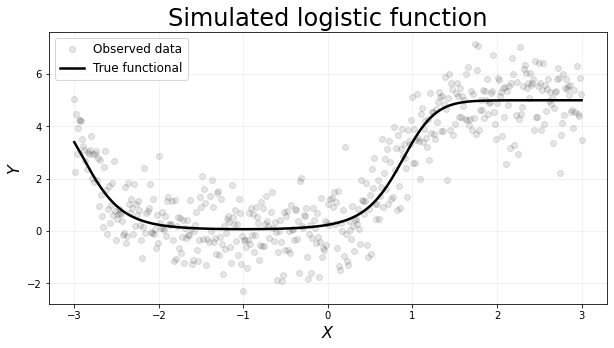

In [4]:
plt.figure(figsize=(10,5))
plt.title("Simulated logistic function", fontsize=24)
plt.xlabel(r"$X$", fontsize = 16)
plt.ylabel(r"$Y$", fontsize = 16)
plt.plot(x, y, 'ko', alpha=0.1, label = "Observed data")
plt.plot(x, f, "k", lw=2.5, label = "True functional")
plt.grid(alpha = 0.2)
plt.legend(fontsize=12)
plt.plot()
plt.show()

### Polynomial regression

Looking at the graph of the simulated data, a polynomial regression seems like an ideal candidate for the model. An
alternative would be some kind of scaling of a sinusoidal function. Note, however, that there does not seem to be a
constant periodic term. A polynomial model is more flexible than the sinusoidal model due to the aperiodic terms.
Up to this point we would simply fit several polynomial models to the data. Let's start with that process to visualize
different function approximations over the entire dataset.

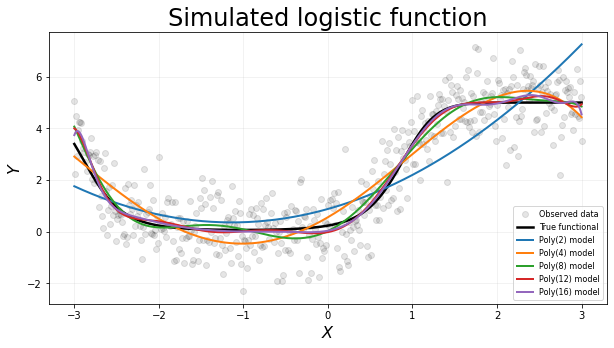

In [5]:
plt.figure(figsize=(10,5))
plt.title("Simulated logistic function", fontsize=24)
plt.xlabel(r"$X$", fontsize = 16)
plt.ylabel(r"$Y$", fontsize = 16)
plt.plot(x, y, 'ko', alpha=0.1, label = "Observed data")
plt.plot(x, f, "k", lw = 2.5, label = "True functional")

# Restrict to even polynomials only
for d in [2, 4, 8, 12, 16]:
    # Get predictions for the model
    poly_model = PolynomialRegression(d)
    poly_model.fit(x, y)
    yhat = poly_model.predict(x)
    plt.plot(x, yhat, lw = 2, label = f"Poly({d}) model")

plt.grid(alpha = 0.2)
plt.legend(fontsize=8)
plt.plot()
plt.show()

The plots above indicate some higher degree polynomial is ideal, but it is unclear from fitting over the entire dataset
which of the polynomial approximations for this model is suitable. Keep in mind that we only know the black line because
we simulated it ourselves, but it is always unknown in practice. There would be no need for a modeler if we knew this model
directly from theory or otherwise.)

We can compare MSE scores under each model for a better idea. This is similar to computing AIC or BIC estimates for the
model, but is driven by prediction error instead of one of those criteria. You may wonder why the change in metric. In
prediction-driven modeling, our goal is to minimize prediction error and we will admit small model bias if we can make
good predictions. The next table illustrates that we can minimize MSE by letting the degree of the polynomial increase
arbitrarily.

In [6]:
poly_scores = {"degree": [], "score": []}
for d in range(15):
    poly_model = PolynomialRegression(d)
    poly_model.fit(x, y)
    _score = poly_model.score(x, y)
    poly_scores["degree"].append(d)
    poly_scores["score"].append(_score)

# Here is the true MSE for our data model
print(f"True MSE = {mean_squared_error(f, y):.6f}")

# This DataFrame has the MSE for different candidate models
pd.DataFrame(poly_scores)

True MSE = 0.846627


,degree,score
0,0,5.367089
1,1,2.843752
2,2,1.666443
3,3,1.090491
4,4,1.009857
5,5,0.989457
6,6,0.862056
7,7,0.861483
8,8,0.847938
9,9,0.836245


Even in a prediction setting, we do not want to let this prediction error go to zero. We would recognize immediately
that the model does not generalize well. A first step at solving this problem is to hold back some of the data used to
learn the model to estimate how well the model generalizes on one validation dataset. Let's try that first.

### Polynomial regression using a validation dataset

Now we are going to estimate prediction error using one validation dataset. As we will see, cross validation will be
preferable for this kind of problem (it is not in all cases, such as machine learning problems using neural networks).
The main convenience here is in splitting the data with a helper function. A general rule of thumb is to hold 75\% or
80\% of your data for training and the remainder for testing. Also see Chapter 7 of *The Elements of Statistical Learning*
for a discussion on using a portion of the data for validation and testing. The next plot shows the data after we randomly
split it into training and validation datasets.

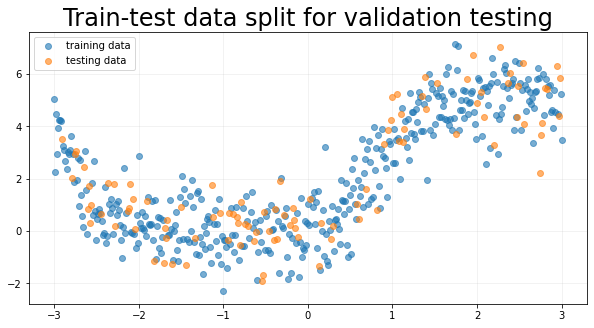

In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size = 0.8, shuffle = True)

plt.figure(figsize = (10, 5))
plt.title("Train-test data split for validation testing", fontsize = 24)
plt.plot(xtrain, ytrain, 'o', alpha = 0.6, label = "training data")
plt.plot(xtest, ytest, 'o', alpha = 0.6, label = "testing data")
plt.grid(alpha = 0.2)
plt.legend()
plt.show()

Now we can apply the same general method for scoring each model, but we will score it over the training and testing data.
There is no need to plot these models because we are only concerned with model selection at this point.

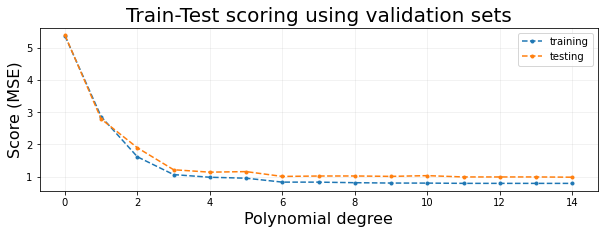

In [8]:
model_scores = {"degree": [], "train_score": [], "test_score": []}

for d in range(15):
    pmodel = PolynomialRegression(d)
    pmodel.fit(xtrain, ytrain)

    model_scores["degree"].append(d)
    model_scores["train_score"].append(pmodel.score(xtrain, ytrain))
    model_scores["test_score"].append(pmodel.score(xtest, ytest))

plt.figure(figsize = (10, 3))
plt.title("Train-Test scoring using validation sets", fontsize=20)
plt.plot(model_scores["degree"], model_scores["train_score"], '.--', label = "training")
plt.plot(model_scores["degree"], model_scores["test_score"], ".--", label = "testing")
plt.xlabel("Polynomial degree", fontsize = 16)
plt.ylabel("Score (MSE)", fontsize = 16)
plt.grid(alpha = 0.2)
plt.legend()
plt.show()

We can see from the plot that the test error exceeds the training error starting at $d = 2$. If we were fitting this model
using this method, that would mean taking the model of degree 2 instead of a larger model for the data. If we consider the
plot of the models over the entire dataset, then it is evident that the degree 2 model is not a good fit to the data!
Regarding our two main goals, model selection and assessement, the model we would select from this procedure is clearly not
adequate for the data.

The drawback here is that we are averaging over one instance of the out-of-sample data. This is where cross validation is
advantageous. We can split the data multiple times, learning the model with multiple independent testing sets. This enables
uncertainty quantification. Now we will finally use cross validation to learn the model.

### Polynomial regression using K=10 fold cross validation

Now we do CV. A typical framework is to fit the model using $K=5$ or $K=10$, depending on the dimensionality of the
training data. In this case we have 500 training points, so splitting the data into 10 groups is sensible. Note the
size of the training dataset shrinks with the number of partitions we make. Your results will vary by the choice of $K$.
For this exercise, I'm going to use $K = 10$. The model selected with $K = 10$ is different from the model with $K = 5$.
**I highly recommend experimenting with the next two cells to see how the results vary.

The setup I'd like to show uses scikit-learn's `cross_validate` method, which does the cross validation automatically
and returns a dictionary of model scores. We will store the results in a numpy array (matrix) where the rows indicate 
the degree of the polynomial and the columns are the prediction error estimates in each fold of the data. This is 
encapsulating the pseudo-algorithm described in the introduction, but we are avoiding writing that for loop explicitly
by invoking an optimized version of it in `cross_val_score`. 

In [9]:
# This just to show what cross_validate returns in a dictionary form
# Access each of these items as you would with any Python dictionary
cross_validate(PolynomialRegression(5), x, y, return_train_score=True).keys()

dict_keys(['fit_time', 'score_time', 'test_score', 'train_score'])

In [10]:
np.random.seed(654)
# This cell should only compute the models. Tables or plots produced from this
# cell should be computed in later cells. This is a best practice when computing
# models which are time-expensive to compute. It is not as important in this case
# but it is a best practice in general.
n_models = 15
K = 10
cv = {
    "degree": [], 
    "train_mean": [],
    "train_se": [],
    "test_mean": [], 
    "test_se": []
}

for d in range(n_models):
    pmodel = PolynomialRegression(d)
    _cv = cross_validate(pmodel, x, y, cv = K, return_train_score = True)
    _cv_train = _cv["train_score"]
    _cv_test = _cv["test_score"]

    cv["degree"].append(d)
    cv["train_mean"].append(_cv_train.mean())
    cv["train_se"].append(_cv_train.std())
    cv["test_mean"].append(_cv_test.mean())
    cv["test_se"].append(_cv_test.std())

In [11]:
# This is a handy trick for easily making a DataFrame using a dictionary first,
# then casting it into a DataFrame. Appending data to a DataFrame is not the
# easiest task to remember how to do correctly, so the dictionary -> DataFrame
# construction is often preferable to remembering how to append data to the 
# DataFrame directly. These will be easier to extract for plotting in the next step.
cv = pd.DataFrame(cv)
cv

,degree,train_mean,train_se,test_mean,test_se
0,0,5.313406,0.343418,6.387069,3.456872
1,1,2.785535,0.336073,4.102805,4.367031
2,2,1.611426,0.166947,3.279144,3.526722
3,3,1.075638,0.046773,1.625284,0.771461
4,4,0.999903,0.032468,1.528434,1.152076
5,5,0.967345,0.034801,5.174559,8.073120
6,6,0.858774,0.018290,1.360839,1.088510
7,7,0.854649,0.019365,9.298210,19.568431
8,8,0.839753,0.013666,32.686870,73.580126
9,9,0.832971,0.013602,21.919504,47.249067


The above cell has average training and testing errors, along with standard errors for those estimates. Already we can see
from the table that we should trim the list of candidate models to one of at most degree 6. The test error explodes for
$d > 6$ and continues to worsen, so we can eliminate these models as candidates immediately. But we will plot the training
and testing errors to get a better idea of what the graphs look like.

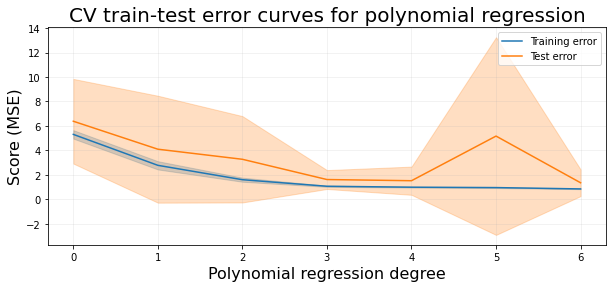

In [12]:
plt.figure(figsize = (10, 4))
plt.title("CV train-test error curves for polynomial regression", fontsize=20)
plt.xlabel("Polynomial regression degree", fontsize = 16)
plt.ylabel("Score (MSE)", fontsize = 16)

plt.plot(cv.degree[:7], cv.train_mean[:7], "C0", label = "Training error")
plt.fill_between(
    cv.degree[:7],
    cv.train_mean[:7] + cv.train_se[:7],
    cv.train_mean[:7] - cv.train_se[:7],
    color = "C0",
    alpha = 0.25
)
plt.plot(cv.degree[:7], cv.test_mean[:7], "C1", label = "Test error")
plt.fill_between(
    cv.degree[:7],
    cv.test_mean[:7] + cv.test_se[:7],
    cv.test_mean[:7] - cv.test_se[:7],
    color = "C1",
    alpha = 0.25
)
plt.grid(alpha = 0.2)
plt.legend()
plt.show()

Our minimizing model is one with degree 6. As noted before, this depends on the number of folds used. It may also
vary due to sampling variation depending on how well your model approximates the data. Bootstrap cross validation
would be robust against these changes, but is beyond what I want to cover here. Reference (7) addresses this point.
For now, with $K=10$, we will accept that a polynomial of degree 6 is the minimizer for the model.

### Polynomial regression using leave one out cross validation

Now we rerun the same exercise as before, except this time we use leave one out cross validation. This is
most simply done by running a for loop over the rows of your data, deleting the $i$th observation from the
training data, and using that point as an estimate of the test error. I do it using the same code as we
used in the last step, but setting `cv = 500` (500 is the dimension of the row space).

In [13]:
# This cell should only compute the models. Tables or plots produced from this
# cell should be computed in later cells. This is a best practice when computing
# models which are time-expensive to compute. It is not as important in this case
# but it is a best practice in general.
n_models = 15
K = 500
cv = {
    "degree": [], 
    "train_mean": [],
    "train_se": [],
    "test_mean": [], 
    "test_se": []
}

for d in range(n_models):
    pmodel = PolynomialRegression(d)
    _cv = cross_validate(pmodel, x, y, cv = K, return_train_score = True)
    _cv_train = _cv["train_score"]
    _cv_test = _cv["test_score"]

    cv["degree"].append(d)
    cv["train_mean"].append(_cv_train.mean())
    cv["train_se"].append(_cv_train.std())
    cv["test_mean"].append(_cv_test.mean())
    cv["test_se"].append(_cv_test.std())

This cell demonstrated my point in the previous section. The last cell took 13.6 seconds to run on my machine.

In [14]:
cv = pd.DataFrame(cv)
cv

,degree,train_mean,train_se,test_mean,test_se
0,0,5.367067,0.009624,5.388622,4.812118
1,1,2.843727,0.008228,2.868708,4.129895
2,2,1.666419,0.004541,1.690459,2.287010
3,3,1.090474,0.003091,1.106745,1.553119
4,4,1.009837,0.002755,1.030401,1.388618
5,5,0.989433,0.002766,1.013570,1.396673
6,6,0.862032,0.002413,0.886544,1.222461
7,7,0.861455,0.002413,0.890063,1.225652
8,8,0.847907,0.002413,0.879484,1.225897
9,9,0.836210,0.002428,0.871894,1.240416


Here we minimize the test error with a polynomial of degree 11 and the test error is decreasing from degree 8 to degree 11.
Notice, however, that the test error increases from degree 6 to degree 7. This is an indicator that we are overfitting the
model at degree 7. Thus, under leave-one-out CV, we should pick the model of degree 6 as the best candidate model for our
data. The next plot is simply for comparison with the previous code. Notice now we have smaller standard errors than before,
so the test error does not diverge at any point.

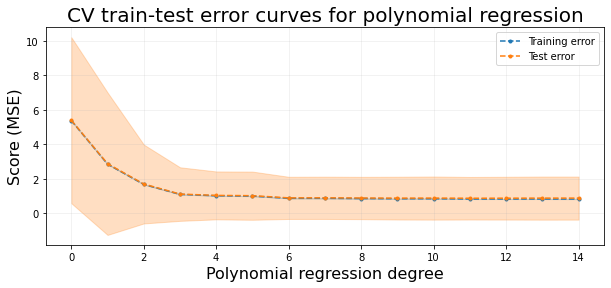

In [15]:
plt.figure(figsize = (10, 4))
plt.title("CV train-test error curves for polynomial regression", fontsize=20)
plt.xlabel("Polynomial regression degree", fontsize = 16)
plt.ylabel("Score (MSE)", fontsize = 16)

plt.plot(cv.degree, cv.train_mean, "C0.--", label = "Training error")
plt.fill_between(
    cv.degree,
    cv.train_mean + cv.train_se,
    cv.train_mean - cv.train_se,
    color = "C0",
    alpha = 0.25
)
plt.plot(cv.degree, cv.test_mean, "C1.--", label = "Test error")
plt.fill_between(
    cv.degree,
    cv.test_mean + cv.test_se,
    cv.test_mean - cv.test_se,
    color = "C1",
    alpha = 0.25
)
plt.grid(alpha = 0.2)
plt.legend()
plt.show()

Now I refit the model on the full dataset with our best polynomial choice to compare it with the true data model.

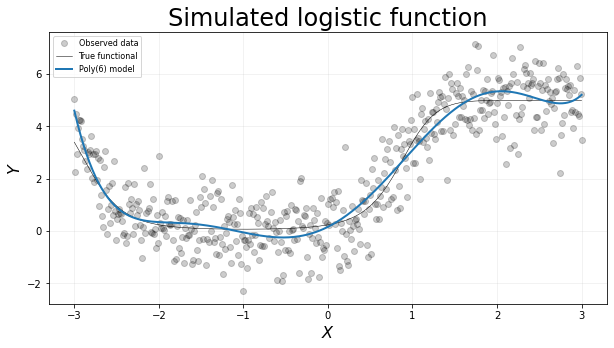

In [16]:
plt.figure(figsize=(10,5))
plt.title("Simulated logistic function", fontsize=24)
plt.xlabel(r"$X$", fontsize = 16)
plt.ylabel(r"$Y$", fontsize = 16)
plt.plot(x, y, 'ko', alpha=0.2, label = "Observed data")
plt.plot(x, f, "k", lw = 0.5, label = "True functional")

# Get predictions for the model
poly_model = PolynomialRegression(6)
poly_model.fit(x, y)
yhat = poly_model.predict(x)

plt.plot(x, yhat, lw = 2, label = f"Poly(6) model")

plt.grid(alpha = 0.2)
plt.legend(fontsize=8)
plt.plot()
plt.show()

Keep in mind, as always, that we cannot actually know the black line in this plot. I've shrunk its width to deemphasize it
in the plot but so that we can compare it with the learned model. As a last step, let's see how our model's MSE compares with
the MSE of the true data model relative to the noise.

In [17]:
print(f"True model MSE: {mean_squared_error(f, y):.4f}")
print(f"Learned model MSE: {mean_squared_error(yhat, y):.4f}")
print(f"True-vs.-learned MSE: {mean_squared_error(yhat, f):.4f}")

True model MSE: 0.8466
Learned model MSE: 0.8621
True-vs.-learned MSE: 0.0680


As you can see when we fit over the whole data model, the polynomial of degree 6 is very comparable to the true function $f$.
Next we will look at how to obtain confidence intervals using bootstrap resampling.

### Bootstrap resampling

As a final step, we obtain confidence estimates for the polynomial of degree 6 using bootstrap resampling. I will show model
estimates of the model in the data space in one graph alongside bootstrap confidence intervals for the data in histograms.
The best model we fit using $K = 10$ fold CV and LOO CV was a polynomial regression model of degree 6, so that is the model
we will focus on here. The `sklearn.utils.resample` method (imported as resample here) does resampling for us. Equivalently,
we could generate $N$ samples $U \sim \mathcal{U}\{1, \ldots, N\}$ from the discrete uniform distribution, where $N$ is the size
of the data. We could then resample from the arrays using this sample $U$. This is sampling with replacement from our data.
We will this resampling $B = 5000$ times, refitting our model under the resampled data each time.

In [18]:
# Number of times to resample the data
B = 5000

# Matrix store for estimates from the model
coefs = np.empty((B, 6 + 1))

for _ in range(B):
    # Resample the data with replacement (default for this method)
    xb, yb = resample(x, y)

    # Fit the model and store its coefficient estimates
    pmodel = PolynomialRegression(6)
    pmodel.fit(xb, yb)
    coefs[_] = pmodel.coef_

Now we want to make two graphs, one of the models in the model space, the other with histograms of the bootstrapped confidence
intervals for each parameter in the model. For the first step, we will loop through the last coefficients matrix and plot the
polynomials in each step.

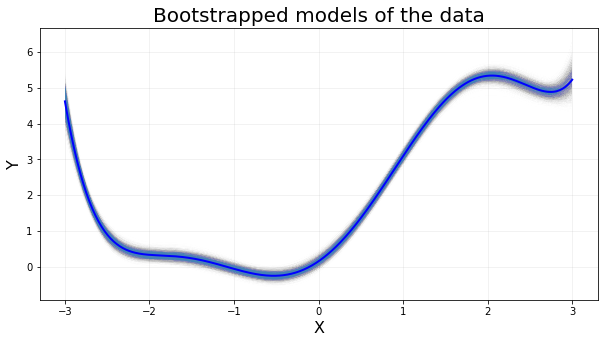

In [19]:
plt.figure(figsize = (10, 5))
plt.title("Bootstrapped models of the data", fontsize = 20)

for b in range(B):
    plt.plot(x, poly(x, coefs[b]), color = 'steelblue', lw = 0.5, alpha = 0.005)

plt.plot(x, poly(x, coefs.mean(axis=0)), color = 'b', lw = 2)
plt.xlabel("X", fontsize = 16)
plt.ylabel("Y", fontsize = 16)
plt.grid(alpha = 0.2)
plt.show()

The dimensionality of the model is a little unfortunate since it has an intercept and 6 coefficients. In such cases,
I recommend plotting the intercept separately from the remaining coefficients. Matplotlib has tools for putting all of
these together in a single, publication-ready plot; see [these docs](https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html#sphx-glr-tutorials-intermediate-tight-layout-guide-py), for example. I would personally use Adobe
Illustrator or InDesign (or inkscape) to put these together into a single graph myself. The workflow there is to export each
plot as an svg and then combine them. If you expected to refit this model several times, then working out the Python code
to programmatically make the plot would definitely be preferable to the procedure I described.

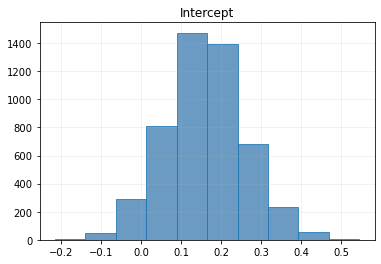

In [20]:
plt.figure(figsize = (6, 4))
plt.hist(coefs[:, 0], color = "steelblue", edgecolor = "C0", alpha = 0.8)
plt.title("Intercept", fontsize=12)
plt.grid(alpha = 0.2)
plt.show()

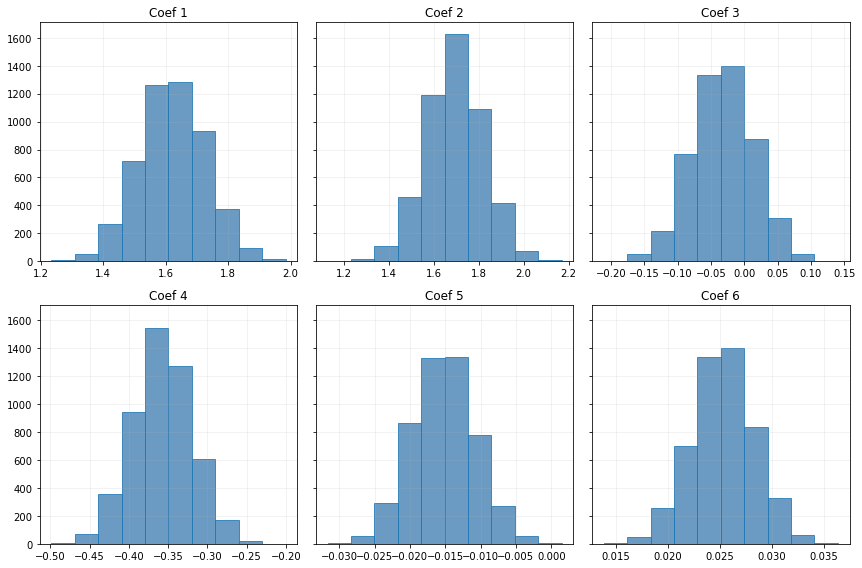

In [21]:
fig, ax = plt.subplots(2, 3, sharex = False, sharey = True, figsize = (12, 8))

k = 1
for row in range(2):
    for col in range(3):
        ax[row, col].hist(coefs[:, k], color = "steelblue", edgecolor = "C0", alpha=0.8)
        ax[row, col].grid(alpha = 0.2)
        ax[row, col].set_title(f"Coef {k}", fontsize = 12)
        k += 1

plt.tight_layout()

One last step we can take is to generate 95\% confidence intervals from the bootstrap intervals. An example is shown below.

In [26]:
bootstrap_ci = np.quantile(coefs, (0.025, 0.975), axis = 0)

for _ in range(6):
    print(f"b{_} 95% CI = [{bootstrap_ci[0, _]:>.4f}, {bootstrap_ci[1, _]:>.4f}]")

b0 95% CI = [-0.0318, 0.3591]
b1 95% CI = [1.4155, 1.8292]
b2 95% CI = [1.4385, 1.9359]
b3 95% CI = [-0.1231, 0.0557]
b4 95% CI = [-0.4316, -0.2817]
b5 95% CI = [-0.0237, -0.0063]


The following references were used to prepare this module. If you're interested in fitting a model using the
statsmodels library and want automated cross validation, then check out the stackoverflow post in (8). Note also
that PDFs for each book are available from [Trevor Hastie's website](https://hastie.su.domains/pub.htm).

## References

(1) James, G., Witten, D., Hastie, T. and Tibshirani, R., 2013. 
*An introduction to statistical learning* (Vol. 112, p. 18). New York: springer.

(2) Hastie, T., Tibshirani, R., Friedman, J.H. and Friedman, J.H., 2009. 
*The elements of statistical learning: data mining, inference, and prediction* (Vol. 2, pp. 1-758). New York: springer.

(3) [Wikipedia Cross Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))

(4) Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V. and Vanderplas, J., 2011. *Scikit-learn: Machine learning in Python.* the Journal of machine Learning research, 12, pp.2825-2830.

(5) [Cross validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)

(6) [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)

(7) [Scikit-learn bootstrap](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.cross_validation.Bootstrap.html)

(8) [Stackoverflow: Using statsmodels models with scikit-learn cross validation](https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible)